<a href="https://colab.research.google.com/github/JGIBIN/jorgegibin/blob/Tech-Challenge-FIAP---Fase/TECHCHALLENGE_FASE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalação das bibliotecas

In [150]:
!pip install prince
!pip install KModes

## Importação das bibliotecas

In [155]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import db_dtypes
import warnings
warnings.filterwarnings("ignore")
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.oauth2 import service_account
import prince
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Criação de um cliente do BigQuery

In [10]:
client = bigquery.Client()

## Classificação das variáveis

In [28]:
sintomas = ['B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112', 'B00113']
sintomas_suspeita = ['B0011', 'B0012', 'B0014']
fizeram_teste = 'B008'
resultado_covid = ['B009B', 'B009D', 'B009F']
doencas = ['B0101', 'B0102', 'B0103', 'B0104', 'B0105', 'B0106']
idade = 'A002'
raca = 'A004'
estado = 'sigla_uf'
escolaridade = 'A005'
sexo = 'A003'
situacao_domicilio = 'V1022'
providencia_tomada_sintomas = ['B0031', 'B0032', 'B0033', 'B0034', 'B0035', 'B0036', 'B0037']
local_buscou_atendimento = ['B0044', 'B0045', 'B0046']
internacao = ['B005', 'B006']
renda = 'C01011'
colunas_consulta = sintomas + sintomas_suspeita + [fizeram_teste] + resultado_covid + doencas +[idade] + [raca] + [estado] + [escolaridade] + [sexo] + [situacao_domicilio] + providencia_tomada_sintomas + local_buscou_atendimento + internacao + [renda]
colunas_string = ','.join(colunas_consulta)
print(colunas_string)

B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,B00111,B00112,B00113,B0011,B0012,B0014,B008,B009B,B009D,B009F,B0101,B0102,B0103,B0104,B0105,B0106,A002,A004,sigla_uf,A005,A003,V1022,B0031,B0032,B0033,B0034,B0035,B0036,B0037,B0044,B0045,B0046,B005,B006,C01011


## Importação dos dataframes para análise

In [36]:
project = 'techchallenge3-454423'
location = 'US'
credentials = service_account.Credentials.from_service_account_file('/content/techchallenge3-454423-3e38a5683336.json')
client = bigquery.Client(credentials=credentials, project=project, location=location)

# Consultar dados no BigQuery
query = f"""
SELECT {colunas_string} FROM basedosdados.br_ibge_pnad_covid.microdados WHERE mes in (9,10,11)
"""
query_job = client.query(query)

# Convertendo os resultados para um DataFrame do pandas
dados = query_job.to_dataframe()
print(dados)

        B0011 B0012 B0013 B0014 B0015 B0016 B0017 B0018 B0019 B00110  ...  \
0           2     2     2     2     2     2     2     2     2      2  ...   
1           2     2     2     2     2     2     2     2     2      2  ...   
2           2     2     2     2     2     2     2     2     2      2  ...   
3           2     2     2     2     2     2     2     2     2      2  ...   
4           2     2     2     2     1     2     2     2     2      2  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
1149192     2     2     2     2     2     2     2     2     2      2  ...   
1149193     2     2     2     2     2     2     2     2     2      2  ...   
1149194     2     2     2     2     2     2     2     2     2      2  ...   
1149195     2     2     2     2     2     2     2     2     2      2  ...   
1149196     2     2     1     2     2     2     2     2     2      2  ...   

        B0034 B0035 B0036 B0037 B0044 B0045 B0046  B005  B006 C01011  
0   

## Análise dos Sintomas:
- Frequência dos sintomas
    - na população geral
    - nos casos que apresentaram algum sintoma
    - nos casos positivos de covid
    - Interdependência entre sintomas de SARS-CoV2

In [30]:
base_analise_sintomas = pd.DataFrame()
base_analise_sintomas[sintomas + resultado_covid] = dados[sintomas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_sintomas[sintomas + resultado_covid] = base_analise_sintomas[sintomas + resultado_covid].astype(bool)
base_analise_sintomas['positivo_covid'] = base_analise_sintomas[resultado_covid].apply(verify_covid, axis=1)
base_analise_sintomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   B0011           1149197 non-null  bool 
 1   B0012           1149197 non-null  bool 
 2   B0013           1149197 non-null  bool 
 3   B0014           1149197 non-null  bool 
 4   B0015           1149197 non-null  bool 
 5   B0016           1149197 non-null  bool 
 6   B0017           1149197 non-null  bool 
 7   B0018           1149197 non-null  bool 
 8   B0019           1149197 non-null  bool 
 9   B00110          1149197 non-null  bool 
 10  B00111          1149197 non-null  bool 
 11  B00112          1149197 non-null  bool 
 12  B00113          1149197 non-null  bool 
 13  B009B           1149197 non-null  bool 
 14  B009D           1149197 non-null  bool 
 15  B009F           1149197 non-null  bool 
 16  positivo_covid  1149197 non-null  bool 
dtypes: bool(17)
memory usage: 1

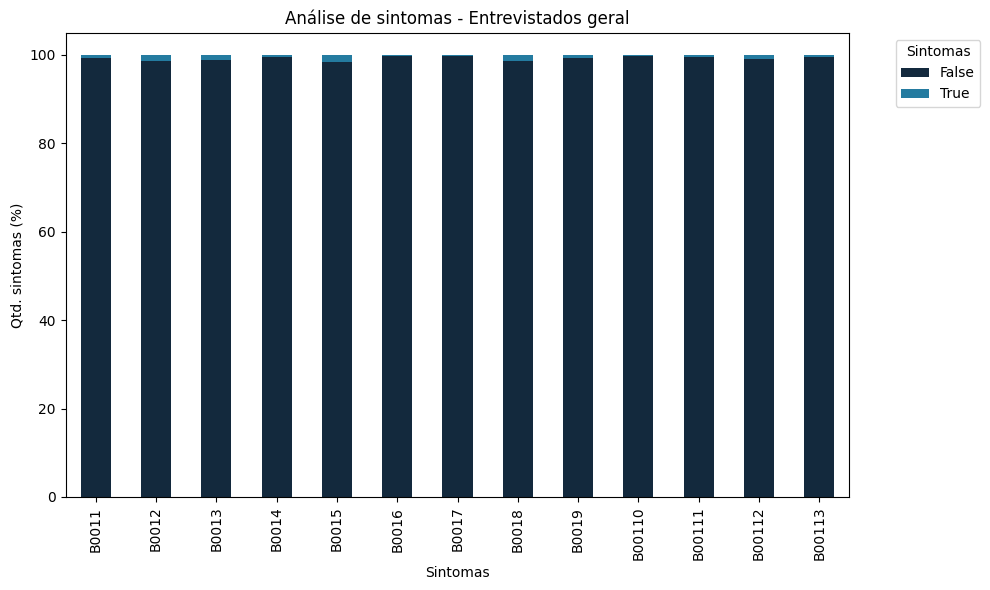

In [56]:
ax = frequencia_sintomas_geral.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#13293D', '#247BA0'])
plt.title('Análise de sintomas - Entrevistados geral')
plt.xlabel('Sintomas')
plt.ylabel('Qtd. sintomas (%)')
plt.legend(title='Sintomas', labels=frequencia_sintomas_geral.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

B0011   False  True 
B0011   79.93  20.07
B0012   65.80  34.20
B0013   72.06  27.94
B0014   89.32  10.68
B0015   57.82  42.18
B0016   92.33   7.67
B0017   91.19   8.81
B0018   64.09  35.91
B0019   81.74  18.26
B00110  91.83   8.17
B00111  90.18   9.82
B00112  75.79  24.21
B00113  90.43   9.57


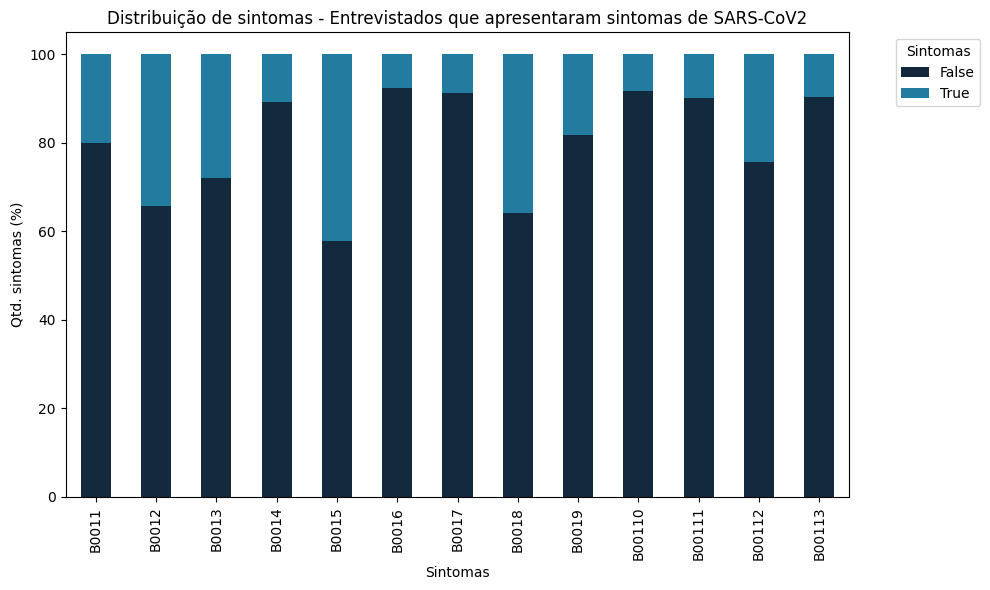

In [73]:
# Filtrando os casos onde pelo menos um sintoma foi apresentado
base_analise_sintomas_algum_sintoma = base_analise_sintomas[base_analise_sintomas[sintomas].any(axis=1)]

# Calculando a frequência dos sintomas para a população que apresentou algum sintoma
frequencia_sintomas_algum_sintoma = pd.DataFrame()
for sintoma in sintomas:
    frequencia_sintomas_algum_sintoma[sintoma] = base_analise_sintomas_algum_sintoma[sintoma].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_sintomas_algum_sintoma = frequencia_sintomas_algum_sintoma.T.round(2)
print(frequencia_sintomas_algum_sintoma)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_sintomas_algum_sintoma.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição de sintomas - Entrevistados que apresentaram sintomas de SARS-CoV2')
plt.xlabel('Sintomas')
plt.ylabel('Qtd. sintomas (%)')

# Adicionando a legenda
plt.legend(title='Sintomas', labels=frequencia_sintomas_algum_sintoma.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()


B0011   False  True 
B0011   94.70   5.30
B0012   94.31   5.69
B0013   95.21   4.79
B0014   96.80   3.20
B0015   93.31   6.69
B0016   97.51   2.49
B0017   97.41   2.59
B0018   95.61   4.39
B0019   95.04   4.96
B00110  97.58   2.42
B00111  94.98   5.02
B00112  94.54   5.46
B00113  97.63   2.37


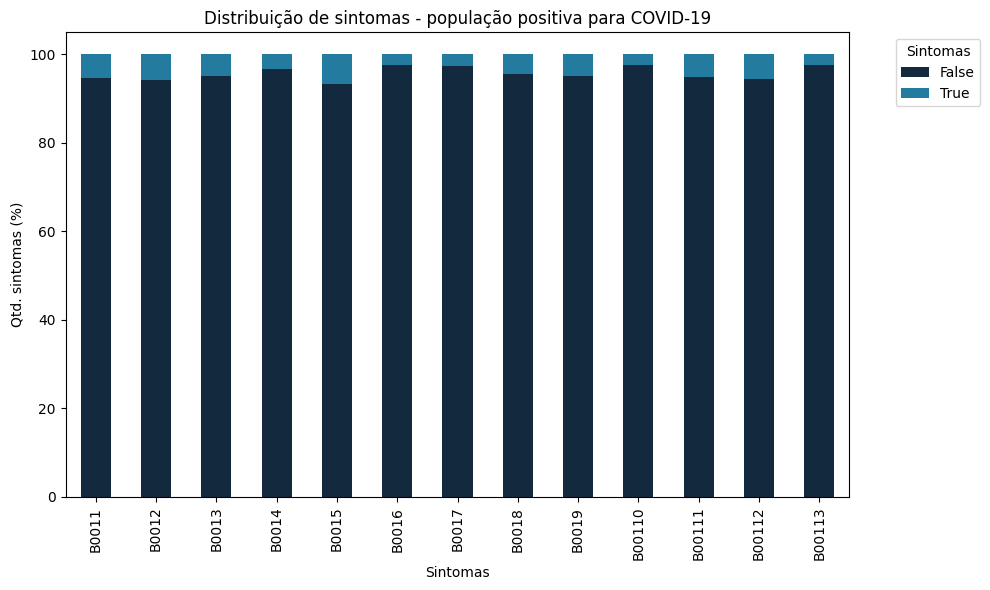

In [72]:
# Filtrando os casos positivos de COVID
base_analise_sintomas_casos_positivos = base_analise_sintomas[base_analise_sintomas['positivo_covid'] == True]

# Calculando a frequência dos sintomas nos casos positivos de COVID
frequencia_sintomas_casos_positivos = pd.DataFrame()
for sintoma in sintomas:
    frequencia_sintomas_casos_positivos[sintoma] = base_analise_sintomas_casos_positivos[sintoma].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_sintomas_casos_positivos = frequencia_sintomas_casos_positivos.T.round(2)
print(frequencia_sintomas_casos_positivos)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_sintomas_casos_positivos.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição de sintomas - população positiva para COVID-19')
plt.xlabel('Sintomas')
plt.ylabel('Qtd. sintomas (%)')

# Adicionando a legenda
plt.legend(title='Sintomas', labels=frequencia_sintomas_casos_positivos.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()

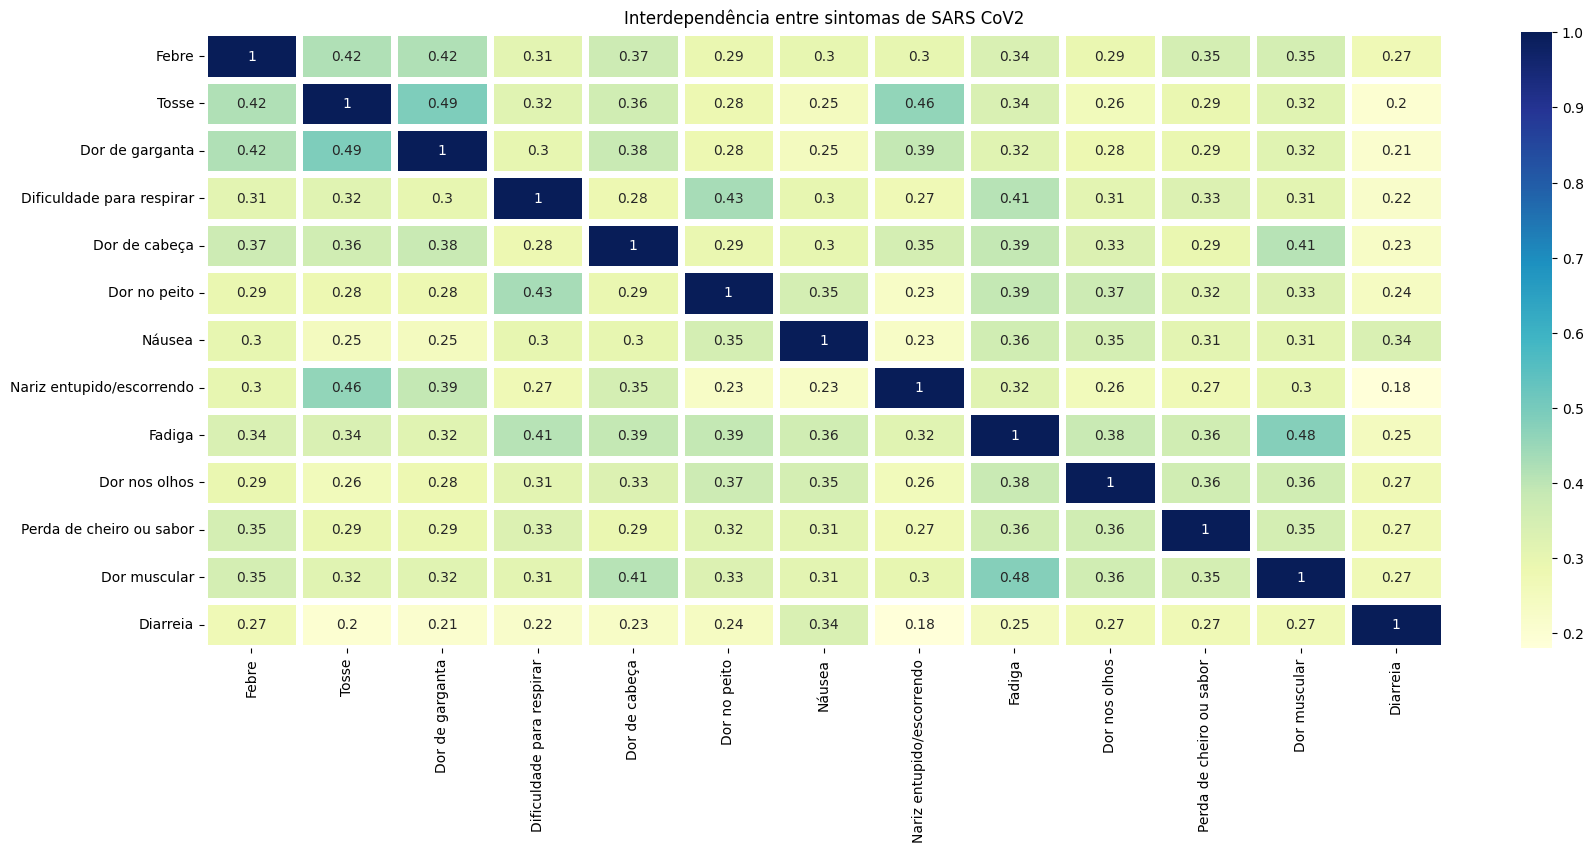

In [69]:
# Calcular a matriz de interdependência e renomear as colunas e índices
matrix_correlacao_sintomas = base_analise_sintomas[sintomas].copy().corr().round(2)
matrix_correlacao_sintomas.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                                          'B00113': 'Diarreia'}, inplace=True)
matrix_correlacao_sintomas.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                                           'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                                           'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                                           'B00113': 'Diarreia'}, inplace=True)

# Gerar o gráfico de interdependência com uma nova paleta de cores
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(data=matrix_correlacao_sintomas, annot=True, linewidths=5, ax=ax, cmap='YlGnBu')
plt.title('Interdependência entre sintomas de SARS CoV2')
plt.show()


## Análise de doenças crônicas:
- Frequência das doênças crônicas
    - na população geral
    - nos casos que apresentaram algum sintoma
    - nos casos positivos de covid

In [169]:
#preparação da base de dados para análises doenças crônicas
base_analise_doencas = pd.DataFrame()
base_analise_doencas[sintomas + doencas + resultado_covid] = dados[sintomas + doencas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_doencas[sintomas + doencas + resultado_covid] = base_analise_doencas[sintomas + doencas + resultado_covid].astype(bool)
base_analise_doencas['positivo_covid'] = base_analise_doencas[resultado_covid].apply(verify_covid, axis=1)
base_analise_doencas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   B0011           1149197 non-null  bool 
 1   B0012           1149197 non-null  bool 
 2   B0013           1149197 non-null  bool 
 3   B0014           1149197 non-null  bool 
 4   B0015           1149197 non-null  bool 
 5   B0016           1149197 non-null  bool 
 6   B0017           1149197 non-null  bool 
 7   B0018           1149197 non-null  bool 
 8   B0019           1149197 non-null  bool 
 9   B00110          1149197 non-null  bool 
 10  B00111          1149197 non-null  bool 
 11  B00112          1149197 non-null  bool 
 12  B00113          1149197 non-null  bool 
 13  B0101           1149197 non-null  bool 
 14  B0102           1149197 non-null  bool 
 15  B0103           1149197 non-null  bool 
 16  B0104           1149197 non-null  bool 
 17  B0105           1149197 non

B0101  False  True 
B0101  94.13   5.87
B0102  84.81  15.19
B0103  95.01   4.99
B0104  97.17   2.83
B0105  96.99   3.01
B0106  98.91   1.09


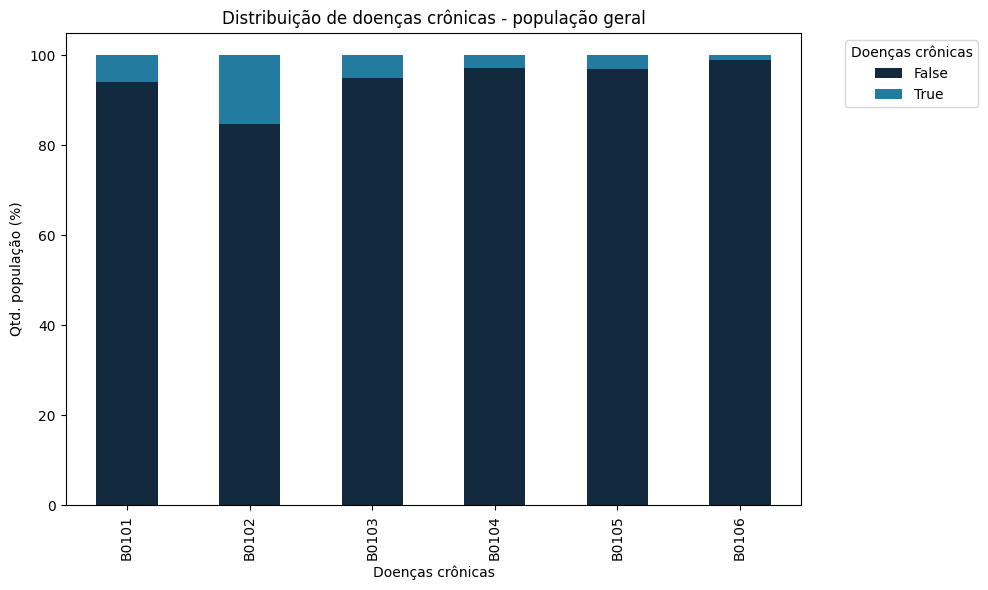

In [74]:
# Calculando a frequência das doenças crônicas na população
frequencia_doencas_geral = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_geral[doenca] = base_analise_doencas[doenca].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_doencas_geral = frequencia_doencas_geral.T.round(2)
print(frequencia_doencas_geral)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_doencas_geral.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição de doenças crônicas - população geral')
plt.xlabel('Doenças crônicas')
plt.ylabel('Qtd. população (%)')

# Adicionando a legenda
plt.legend(title='Doenças crônicas', labels=frequencia_doencas_geral.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()

B0101  False  True 
B0101  90.79   9.21
B0102  77.04  22.96
B0103  88.75  11.25
B0104  93.95   6.05
B0105  91.62   8.38
B0106  97.89   2.11


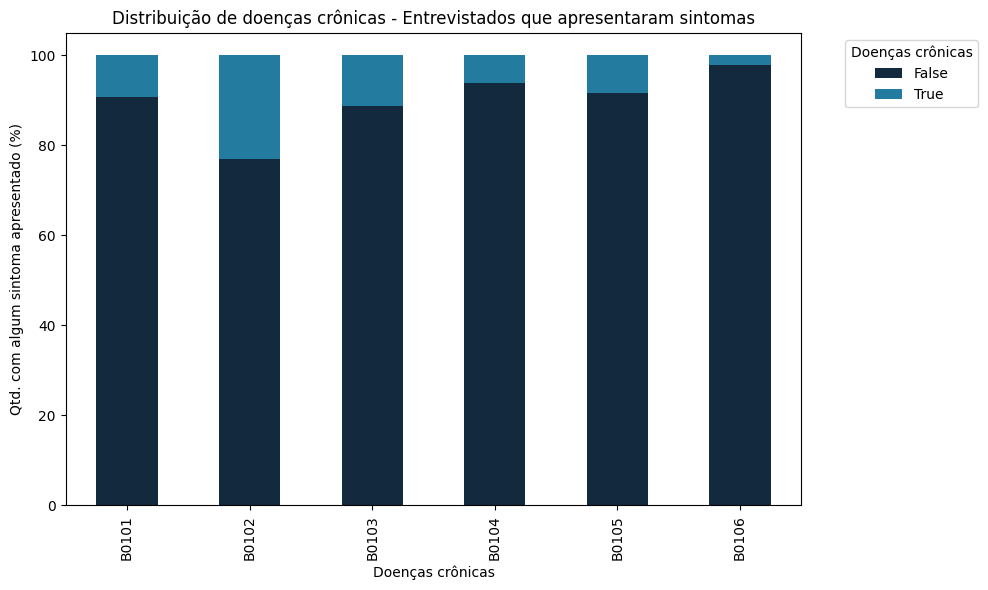

In [79]:
# Filtrando os casos onde pelo menos um sintoma foi apresentado
base_analise_doencas_algum_sintoma = base_analise_doencas[base_analise_doencas[sintomas].any(axis=1)]

# Calculando a frequência das doenças crônicas nos casos com algum sintoma
frequencia_doencas_algum_sintoma = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_algum_sintoma[doenca] = base_analise_doencas_algum_sintoma[doenca].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_doencas_algum_sintoma = frequencia_doencas_algum_sintoma.T.round(2)
print(frequencia_doencas_algum_sintoma)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_doencas_algum_sintoma.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição de doenças crônicas - Entrevistados que apresentaram sintomas')
plt.xlabel('Doenças crônicas')
plt.ylabel('Qtd. com algum sintoma apresentado (%)')

# Adicionando a legenda
plt.legend(title='Doenças crônicas', labels=frequencia_doencas_algum_sintoma.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()

B0101  False  True 
B0101  92.02   7.98
B0102  81.49  18.51
B0103  93.66   6.34
B0104  96.47   3.53
B0105  95.74   4.26
B0106  98.68   1.32


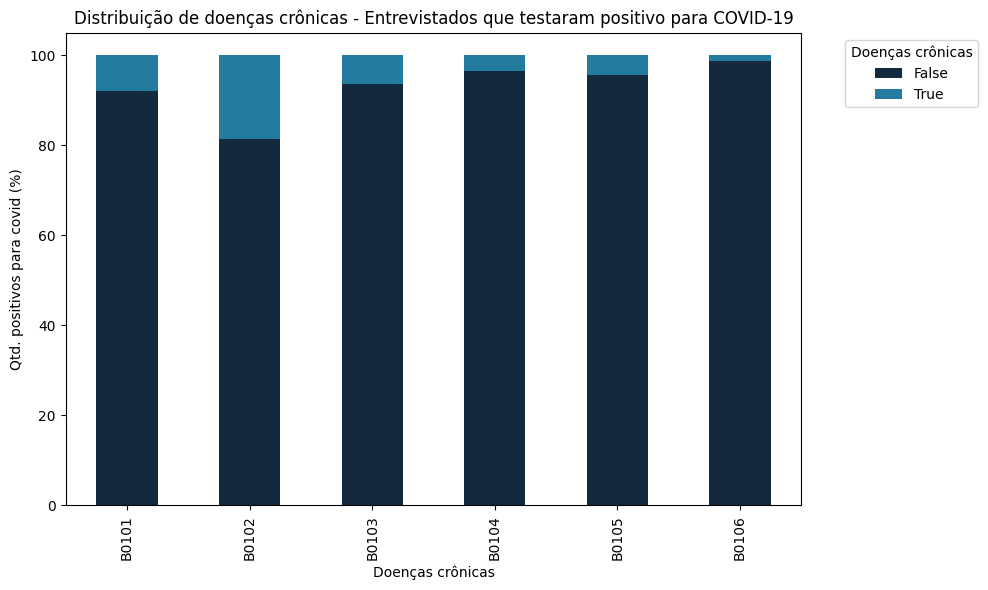

In [78]:
# Filtrando os casos positivos para COVID
base_analise_doencas_casos_positivos = base_analise_doencas[base_analise_doencas['positivo_covid'] == True]

# Calculando a frequência das doenças crônicas nos casos positivos para COVID
frequencia_doencas_casos_positivos = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_casos_positivos[doenca] = base_analise_doencas_casos_positivos[doenca].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_doencas_casos_positivos = frequencia_doencas_casos_positivos.T.round(2)
print(frequencia_doencas_casos_positivos)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_doencas_casos_positivos.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição de doenças crônicas - Entrevistados que testaram positivo para COVID-19')
plt.xlabel('Doenças crônicas')
plt.ylabel('Qtd. positivos para covid (%)')

# Adicionando a legenda
plt.legend(title='Doenças crônicas', labels=frequencia_doencas_casos_positivos.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()

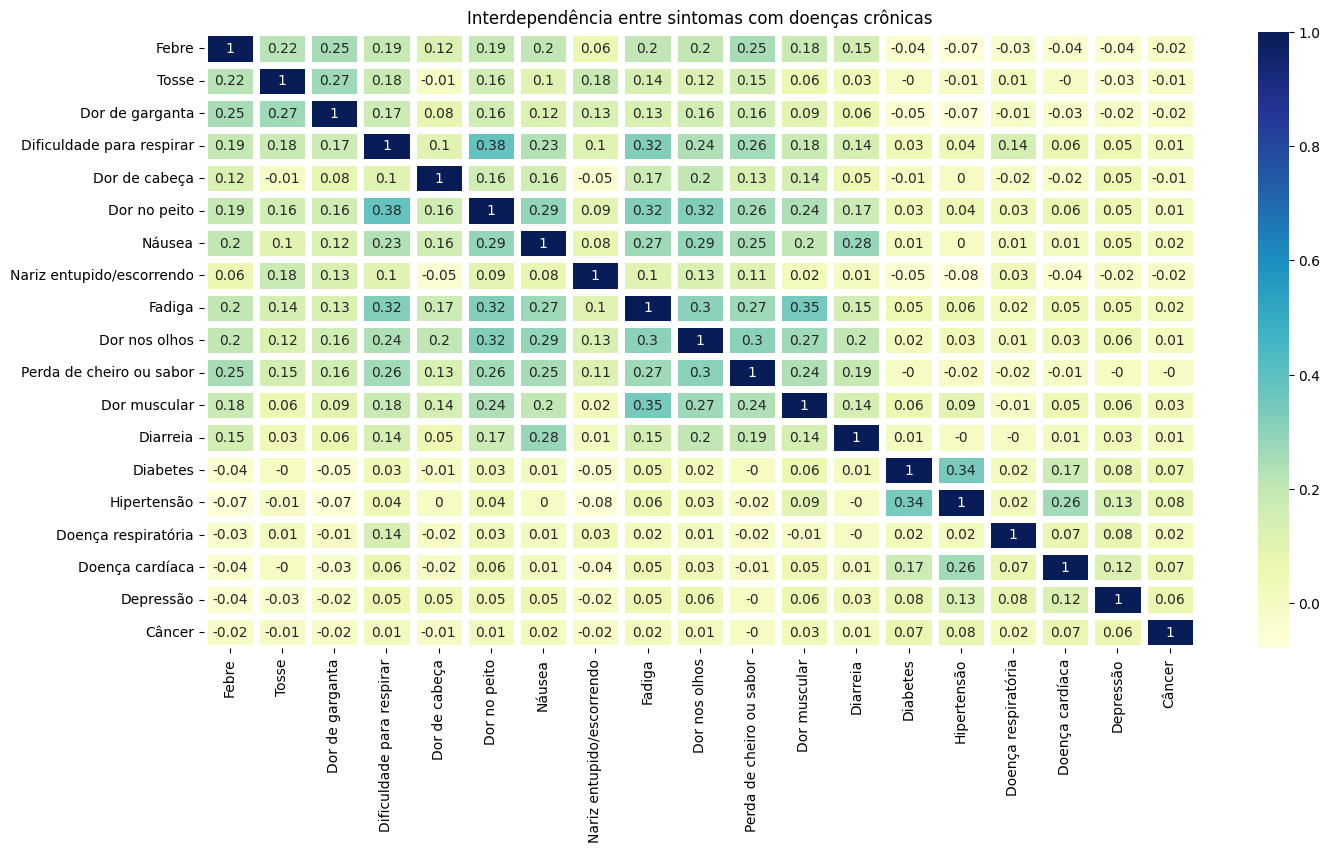

In [80]:
#Matrix de correlação das doenças crônicas com os sintomas para os casos que apresentaram algum sintoma
base_analise_doencas_algum_sintoma = base_analise_doencas[base_analise_doencas[sintomas].any(axis=1)][sintomas + doencas]
matrix_correlacao_doencas = base_analise_doencas_algum_sintoma.copy().corr().round(2)
matrix_correlacao_doencas.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                          'B00113': 'Diarreia', 'B0101': 'Diabetes', 'B0102': 'Hipertensão', 'B0103': 'Doença respiratória',
                          'B0104': 'Doença cardíaca', 'B0105': 'Depressão', 'B0106': 'Câncer'}, inplace=True)
matrix_correlacao_doencas.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                          'B00113': 'Diarreia', 'B0101': 'Diabetes', 'B0102': 'Hipertensão', 'B0103': 'Doença respiratória',
                          'B0104': 'Doença cardíaca', 'B0105': 'Depressão', 'B0106': 'Câncer'}, inplace=True)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=matrix_correlacao_doencas, annot=True, linewidths=5, ax=ax, cmap='YlGnBu')
plt.title('Interdependência entre sintomas com doenças crônicas')
plt.show()

## 3. Entrevistados que foram internados:
- Frequência das proviências tomadas em casos que apresentaram algum sintoma
- Frequência dos locais que buscou atendimento em casos que apresentaram algum sintoma
- Frequência de internação e intubação em casos que apresentaram algum sintoma
- Interdependência com internação e intubação com sintomas em casos que apresentaram algum sintoma
- Distribuição de idades em casos de internação e intubação em casos que apresentaram algum sintoma

***os valores foram convertidos para valores booleanos, onde 1 é true e demais representam false***

In [81]:
#preparação da base de dados
base_analise_internacao = pd.DataFrame()
base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao] = dados[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao].copy().map(convertCategoricaltoBool)
base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao] = base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao].astype(bool)
base_analise_internacao[idade] = dados[idade].copy().astype(int)
base_analise_internacao = base_analise_internacao[base_analise_internacao[sintomas].any(axis=1)]
base_analise_internacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44950 entries, 4 to 1149196
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   B0011   44950 non-null  bool 
 1   B0012   44950 non-null  bool 
 2   B0013   44950 non-null  bool 
 3   B0014   44950 non-null  bool 
 4   B0015   44950 non-null  bool 
 5   B0016   44950 non-null  bool 
 6   B0017   44950 non-null  bool 
 7   B0018   44950 non-null  bool 
 8   B0019   44950 non-null  bool 
 9   B00110  44950 non-null  bool 
 10  B00111  44950 non-null  bool 
 11  B00112  44950 non-null  bool 
 12  B00113  44950 non-null  bool 
 13  B0101   44950 non-null  bool 
 14  B0102   44950 non-null  bool 
 15  B0103   44950 non-null  bool 
 16  B0104   44950 non-null  bool 
 17  B0105   44950 non-null  bool 
 18  B0106   44950 non-null  bool 
 19  B0031   44950 non-null  bool 
 20  B0032   44950 non-null  bool 
 21  B0033   44950 non-null  bool 
 22  B0034   44950 non-null  bool 
 23  B0035   44950 

B0031  True   False
B0031  54.10  45.90
B0032   2.17  97.83
B0033  45.40  54.60
B0034   8.16  91.84
B0035   1.65  98.35
B0036   0.33  99.67
B0037   1.63  98.37


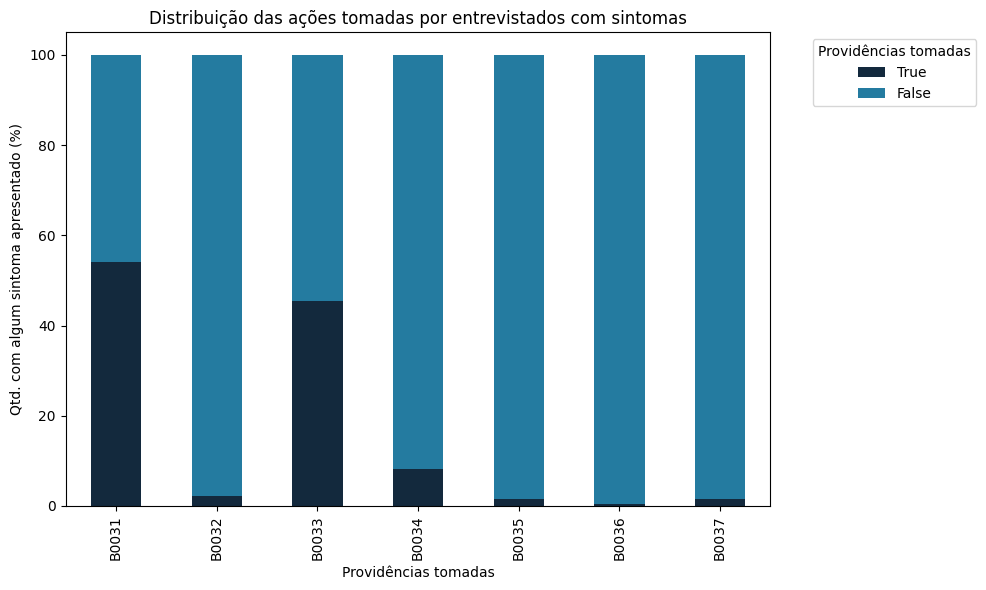

In [94]:
# Calculando a frequência das providências tomadas para os casos de entrevistados com algum sintoma
frequencia_providencias = pd.DataFrame()
for providencia in providencia_tomada_sintomas:
    frequencia_providencias[providencia] = base_analise_internacao[providencia].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_providencias = frequencia_providencias.T.round(2)
print(frequencia_providencias)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_providencias.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição das ações tomadas por entrevistados com sintomas')
plt.xlabel('Providências tomadas')
plt.ylabel('Qtd. com algum sintoma apresentado (%)')

# Adicionando a legenda
plt.legend(title='Providências tomadas', labels=frequencia_providencias.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()

B0031  True   False
B0031  54.10  45.90
B0032   2.17  97.83
B0033  45.40  54.60
B0034   8.16  91.84
B0035   1.65  98.35
B0036   0.33  99.67
B0037   1.63  98.37


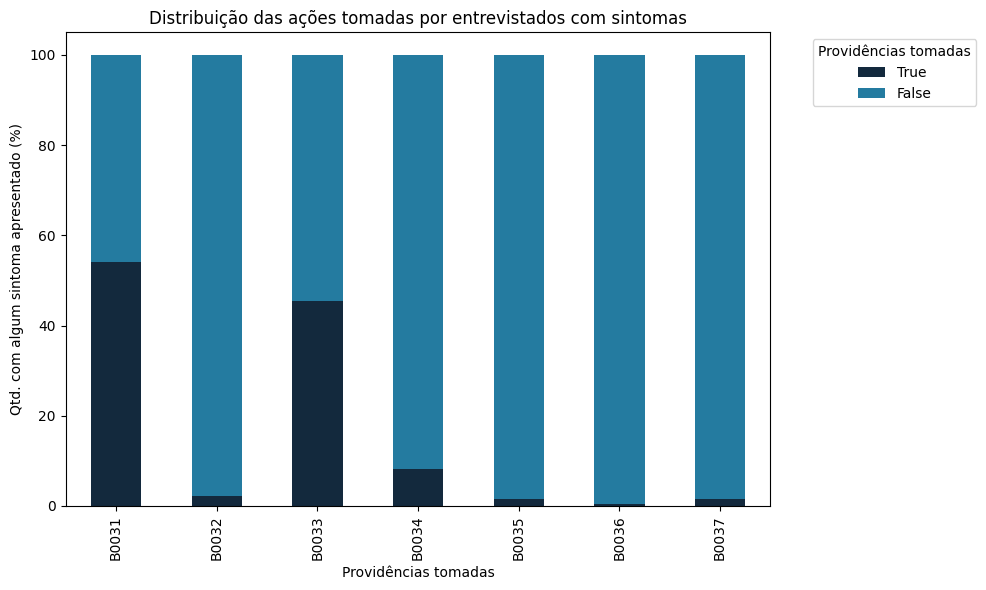

In [95]:
# Calculando a frequência das providências tomadas para os casos de entrevistados com algum sintoma
frequencia_providencias = pd.DataFrame()
for providencia in providencia_tomada_sintomas:
    frequencia_providencias[providencia] = base_analise_internacao[providencia].value_counts(normalize=True) * 100

# Transpondo o DataFrame e arredondando os valores
frequencia_providencias = frequencia_providencias.T.round(2)
print(frequencia_providencias)

# Definindo as cores personalizadas para as barras
colors = ['#13293D', '#247BA0']

# Gerando o gráfico de barras empilhadas com a cor personalizada
ax = frequencia_providencias.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição das ações tomadas por entrevistados com sintomas')
plt.xlabel('Providências tomadas')
plt.ylabel('Qtd. com algum sintoma apresentado (%)')

# Adicionando a legenda
plt.legend(title='Providências tomadas', labels=frequencia_providencias.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando o layout para não sobrepor a legenda com o gráfico
plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [96]:
#frequência de internação em função dos casos que apresentaram algum sintoma
frequencia_internacao = pd.DataFrame()
for tipo_internacao in internacao:
    frequencia_internacao[tipo_internacao] = base_analise_internacao[tipo_internacao].value_counts(normalize=True) * 100
frequencia_internacao = frequencia_internacao.T.round(2)
print(frequencia_internacao)

B005  False  True 
B005  98.71   1.29
B006  99.71   0.29


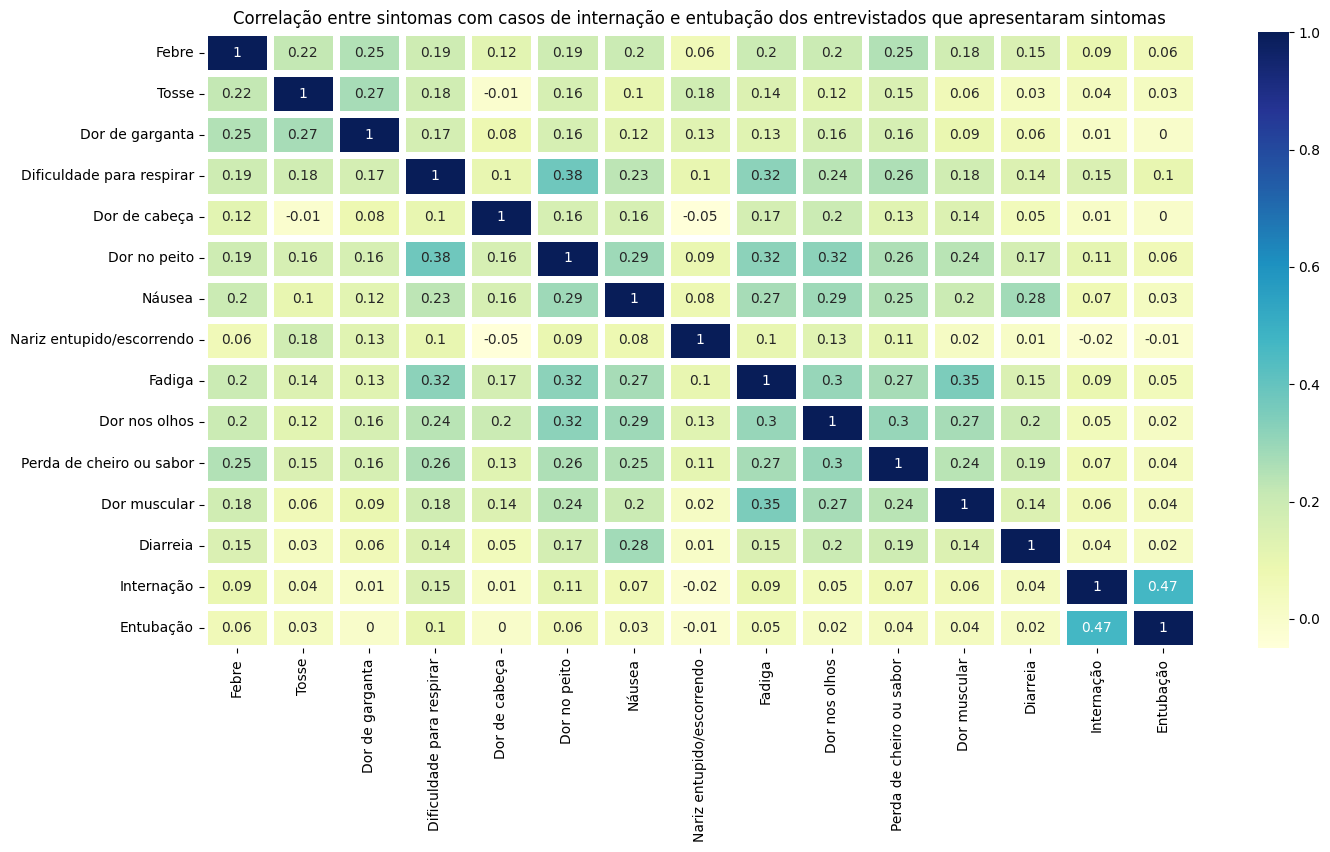

In [170]:
#correlação entre sintomas com casos de internação e entubação
matrix_correlacao_internacao = base_analise_internacao[sintomas + internacao].copy().corr().round(2)
matrix_correlacao_internacao.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                          'B00113': 'Diarreia', 'B005': 'Internação', 'B006': 'Entubação'}, inplace=True)
matrix_correlacao_internacao.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                          'B00113': 'Diarreia', 'B005': 'Internação', 'B006': 'Entubação'}, inplace=True)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=matrix_correlacao_internacao, annot=True, linewidths=5, ax=ax, cmap='YlGnBu')
plt.title('Correlação entre sintomas com casos de internação e entubação dos entrevistados que apresentaram sintomas')
plt.show()

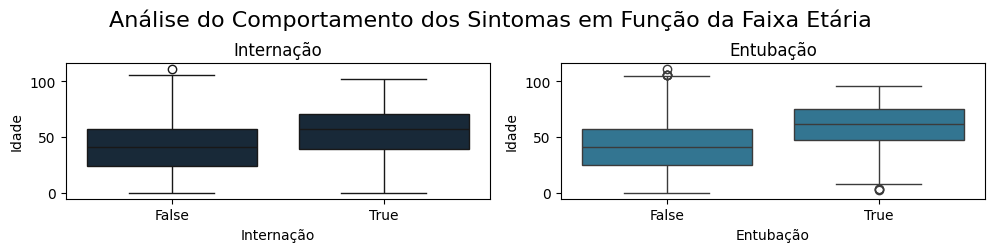

In [121]:
# Boxplot de análise do comportamento dos sintomas em função da faixa etária
base_internacao_idade = base_analise_internacao[internacao + [idade]].copy()
base_internacao_idade.rename(columns={'B005': 'Internação', 'B006': 'Entubação', 'A002': 'Idade'}, inplace=True)

# Definindo as cores personalizadas
cores = ['#13293D', '#247BA0']

plt.figure(figsize=(15, 10))
for i, col in enumerate(['Internação', 'Entubação']):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=base_internacao_idade[col], y=base_internacao_idade['Idade'], color=cores[i])  # Cor personalizada
    plt.title(col)

# Adicionando título geral e centralizando
plt.suptitle('Análise do Comportamento dos Sintomas em Função da Faixa Etária', fontsize=16, x=0.33)

plt.tight_layout()
plt.show()


## 4. Idade e Assintomáticos:
- Distribuição da idade nos casos assintomáticos

In [125]:
#preparção da base de dados
base_analise_assintomaticos = pd.DataFrame()
base_analise_assintomaticos[sintomas + resultado_covid] = dados[sintomas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_assintomaticos[sintomas + resultado_covid] = base_analise_assintomaticos[sintomas + resultado_covid].astype(bool)
base_analise_assintomaticos[idade] = dados[idade].copy().astype(int)
base_analise_assintomaticos['positivo_covid'] = base_analise_assintomaticos[resultado_covid].apply(verify_covid, axis=1)
base_analise_assintomaticos = base_analise_assintomaticos[base_analise_assintomaticos['positivo_covid'] == True]
base_analise_assintomaticos['contagem_sintomas'] = base_analise_assintomaticos[sintomas].sum(axis=1)
base_analise_assintomaticos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32922 entries, 15 to 1149196
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   B0011              32922 non-null  bool 
 1   B0012              32922 non-null  bool 
 2   B0013              32922 non-null  bool 
 3   B0014              32922 non-null  bool 
 4   B0015              32922 non-null  bool 
 5   B0016              32922 non-null  bool 
 6   B0017              32922 non-null  bool 
 7   B0018              32922 non-null  bool 
 8   B0019              32922 non-null  bool 
 9   B00110             32922 non-null  bool 
 10  B00111             32922 non-null  bool 
 11  B00112             32922 non-null  bool 
 12  B00113             32922 non-null  bool 
 13  B009B              32922 non-null  bool 
 14  B009D              32922 non-null  bool 
 15  B009F              32922 non-null  bool 
 16  A002               32922 non-null  int64
 17  positivo_covid

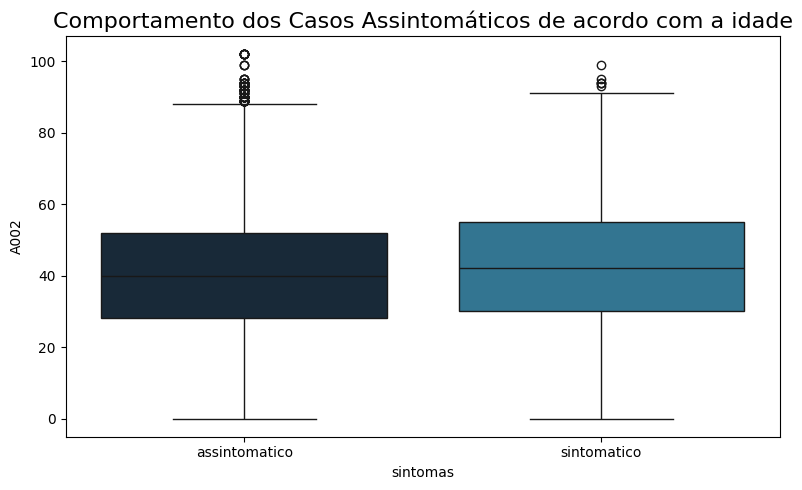

In [131]:
def verify_sintomas(contagem):
    if(int(contagem) > 0):
        return 'sintomatico'
    else:
        return 'assintomatico'

# Boxplot do comportamento dos casos assintomáticos em função da idade
df_contagem_sintomas = base_analise_assintomaticos[['contagem_sintomas', idade]]
df_contagem_sintomas['sintomas'] = base_analise_assintomaticos['contagem_sintomas'].apply(verify_sintomas)

# Definindo as cores personalizadas
cores = ['#13293D', '#247BA0']

# Gerando o gráfico
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_contagem_sintomas['sintomas'], y=df_contagem_sintomas[idade], palette=cores)  # Cor personalizada
plt.title('Comportamento dos Casos Assintomáticos de acordo com a idade', fontsize=16, x=0.5)  # Título centralizado
plt.tight_layout()
plt.show()


## 5. Análise Socioeconômicas:
- Frequência proporcional de suspeita de COVID-19 em função da localização residencial (urbana ou rural)
- Frequência proporcional de suspeita de COVID-19 em função da escolaridade
- Frequência proporcional de suspeita de COVID-19 em função da faixa de renda

*Os valores de todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais false*

*Foram considerados como casos de suspeita de infecção por SARS-CoV2 o entrevistado que apresentou os seguintes 3 sintomas simutâneos (tosse, febre e dificuldade de respirar).*

In [132]:
#preparação da base de dados
base_analise_economica = pd.DataFrame()
base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]] = dados[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]].copy().map(convertCategoricaltoBool)
base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]] = base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]].astype(bool)
base_analise_economica[[escolaridade] + [situacao_domicilio] + [renda]] = dados[[escolaridade] + [situacao_domicilio] + [renda]].copy().fillna('-1')
base_analise_economica['positivo_covid'] = base_analise_economica[resultado_covid].apply(verify_covid, axis=1)
base_analise_economica = base_analise_economica[(base_analise_economica['positivo_covid'] == True) | (base_analise_economica[sintomas_suspeita].all(axis=1))]
base_analise_economica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33982 entries, 15 to 1149196
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   B0011           33982 non-null  bool  
 1   B0012           33982 non-null  bool  
 2   B0014           33982 non-null  bool  
 3   B009B           33982 non-null  bool  
 4   B009D           33982 non-null  bool  
 5   B009F           33982 non-null  bool  
 6   A005            33982 non-null  object
 7   V1022           33982 non-null  object
 8   C01011          33982 non-null  object
 9   positivo_covid  33982 non-null  bool  
dtypes: bool(7), object(3)
memory usage: 1.3+ MB


In [133]:
#frequência proporcional de casos positivos em função da situação domiciliar (urbana ou rural)
absoluto = pd.DataFrame()
absoluto[situacao_domicilio] = base_analise_economica[situacao_domicilio].value_counts()
absoluto['total'] = dados[situacao_domicilio].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[situacao_domicilio] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
print(absoluto)

V1022          1          2
V1022   29479.00    4503.00
total  875200.00  273997.00
freq        3.37       1.64


In [134]:
#frequência proporcional de casos positivos em função da escolaridade
absoluto = pd.DataFrame()
absoluto[escolaridade] = base_analise_economica[escolaridade].value_counts()
absoluto['total'] = dados[escolaridade].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[escolaridade] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

A005,5,2,7,6,4,3,8,1
A005,9948.00,6884.00,6007.00,2842.00,2740.00,2028.00,1879.0,1654.00
total,256040.00,387986.00,107441.00,59678.00,107635.00,76092.00,30290.0,124035.00
freq,3.89,1.77,5.59,4.76,2.55,2.67,6.2,1.33


In [135]:
#frequência proporcional de casos positivos em função da faixa de renda
absoluto = pd.DataFrame()
absoluto[renda] = base_analise_economica[renda].value_counts()
absoluto['total'] = dados[renda].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[renda] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

C01011,-1,4,5,6,2,7,3,1,0,8
C01011,14636.00,8045.00,5341.00,3828.00,700.0,655.00,425.00,296.00,49.00,7.00
total,726462.00,189736.00,103125.00,57729.00,30397.0,7720.00,16718.00,14405.00,2848.00,47.00
freq,2.01,4.24,5.18,6.63,2.3,8.48,2.54,2.05,1.72,14.89


## 6. Análise comportamental dos entrevistados:
- Frequência de suspeita de covid em função do estado da federação
- proporcional considerando o total da população do estado da federação
- de casos suspeita de covid do estado da federação em comparação com suspeita de covid com todos os estados da federação
- Frequência do local que buscou atendimento em casos de suspeita de covid

*Os valores de todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais false*

*Foram considerados como casos de suspeita de infecção por SARS-CoV2 o entrevistado que apresentou os seguintes 3 sintomas simutâneos (tosse, febre e dificuldade de respirar).*

In [136]:
#preparação da base de dados

base_analise_comportamento = pd.DataFrame()
base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]] = dados[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]].copy().map(convertCategoricaltoBool)
base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]] = base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]].astype(bool)
base_analise_comportamento[[renda, estado]] = dados[[renda, estado]].copy().fillna('-1')
base_analise_comportamento['positivo_covid'] = base_analise_comportamento[resultado_covid].apply(verify_covid, axis=1)
base_analise_comportamento = base_analise_comportamento[(base_analise_comportamento['positivo_covid'] == True) | (base_analise_comportamento[sintomas_suspeita].all(axis=1))]
base_analise_comportamento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33982 entries, 15 to 1149196
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   B0011           33982 non-null  bool  
 1   B0012           33982 non-null  bool  
 2   B0014           33982 non-null  bool  
 3   B009B           33982 non-null  bool  
 4   B009D           33982 non-null  bool  
 5   B009F           33982 non-null  bool  
 6   B0044           33982 non-null  bool  
 7   B0045           33982 non-null  bool  
 8   B0046           33982 non-null  bool  
 9   C01011          33982 non-null  object
 10  sigla_uf        33982 non-null  object
 11  positivo_covid  33982 non-null  bool  
dtypes: bool(10), object(2)
memory usage: 1.1+ MB


In [137]:
#frequencia proporcional de suspeita de covid por estado geral
absoluto = pd.DataFrame()
absoluto[estado] = base_analise_comportamento[estado].value_counts()
absoluto['total'] = dados[estado].value_counts()
absoluto['freq'] = (absoluto[estado] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

sigla_uf,SP,MA,RJ,GO,SC,CE,MG,AM,ES,PA,...,AL,SE,PE,PB,RN,AC,MS,RO,TO,AP
sigla_uf,2321.00,2226.00,2225.00,2113.00,1722.00,1609.00,1564.00,1561.00,1460.00,1363.00,...,1034.0,870.00,859.00,836.00,727.00,713.00,676.00,639.00,598.00,550.00
total,98021.00,61200.00,87405.00,41977.00,70990.00,50536.00,103096.00,31355.00,47511.00,35764.00,...,34450.0,24216.00,50811.00,29687.00,23552.00,18834.00,26434.00,16622.00,15446.00,7677.00
freq,2.37,3.64,2.55,5.03,2.43,3.18,1.52,4.98,3.07,3.81,...,3.0,3.59,1.69,2.82,3.09,3.79,2.56,3.84,3.87,7.16


In [138]:
#frequencia de suspeita de covid por estado somente em casos de suspeita
absoluto = pd.DataFrame()
absoluto[estado] = base_analise_comportamento[estado].value_counts()
absoluto['total'] = base_analise_comportamento[estado].count()
absoluto['freq'] = (absoluto[estado] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

sigla_uf,SP,MA,RJ,GO,SC,CE,MG,AM,ES,PA,...,AL,SE,PE,PB,RN,AC,MS,RO,TO,AP
sigla_uf,2321.00,2226.00,2225.00,2113.00,1722.00,1609.00,1564.0,1561.00,1460.0,1363.00,...,1034.00,870.00,859.00,836.00,727.00,713.0,676.00,639.00,598.00,550.00
total,33982.00,33982.00,33982.00,33982.00,33982.00,33982.00,33982.0,33982.00,33982.0,33982.00,...,33982.00,33982.00,33982.00,33982.00,33982.00,33982.0,33982.00,33982.00,33982.00,33982.00
freq,6.83,6.55,6.55,6.22,5.07,4.73,4.6,4.59,4.3,4.01,...,3.04,2.56,2.53,2.46,2.14,2.1,1.99,1.88,1.76,1.62


In [139]:
#frequência do local que buscou atendimento em casos de suspeita de covid
distribuicao = base_analise_comportamento[local_buscou_atendimento].value_counts().reset_index()
absoluto = pd.DataFrame()
for collum in distribuicao.columns[:-1]:
        absoluto[collum] = [distribuicao[distribuicao[collum] == True]['count'].sum()]
absoluto['NA'] = distribuicao[~distribuicao[absoluto.columns].any(axis=1)]['count'].sum()
absoluto = absoluto.T.round(2)
absoluto['freq'] = ((absoluto.loc[local_buscou_atendimento + ['NA']] / absoluto.sum()[0]) * 100)
absoluto

,0,freq
B0044,288,0.845666
B0045,172,0.505051
B0046,442,1.297862
NA,33154,97.351421


## 7. Análise de perfil dos entrevistados que testaram positivo para SARS-CoV2 com base nos sintomas (MCA + K-means):
*Os valores de todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais false.*

In [140]:
#preparação da base de dados

base_analise_cluster = pd.DataFrame()
base_analise_cluster[sintomas + resultado_covid + doencas] = dados[sintomas + resultado_covid + doencas].copy().map(convertCategoricaltoBool)
base_analise_cluster[sintomas + resultado_covid + doencas] = base_analise_cluster[sintomas + resultado_covid + doencas].astype(bool)
base_analise_cluster['positivo_covid'] = base_analise_cluster[resultado_covid].apply(verify_covid, axis=1)
base_analise_cluster = base_analise_cluster[base_analise_cluster['positivo_covid'] == True]
base_analise_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32922 entries, 15 to 1149196
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   B0011           32922 non-null  bool 
 1   B0012           32922 non-null  bool 
 2   B0013           32922 non-null  bool 
 3   B0014           32922 non-null  bool 
 4   B0015           32922 non-null  bool 
 5   B0016           32922 non-null  bool 
 6   B0017           32922 non-null  bool 
 7   B0018           32922 non-null  bool 
 8   B0019           32922 non-null  bool 
 9   B00110          32922 non-null  bool 
 10  B00111          32922 non-null  bool 
 11  B00112          32922 non-null  bool 
 12  B00113          32922 non-null  bool 
 13  B009B           32922 non-null  bool 
 14  B009D           32922 non-null  bool 
 15  B009F           32922 non-null  bool 
 16  B0101           32922 non-null  bool 
 17  B0102           32922 non-null  bool 
 18  B0103           32922 non-nu

In [144]:
#Análise MCA (Análise de Correspondência Múltipla) nos dados positivos de COVID-19.
variaveis_categoricas = base_analise_cluster[sintomas + doencas].copy()
mca = prince.MCA(n_components=2)
mca = mca.fit(variaveis_categoricas)
variaveis_mca = mca.transform(variaveis_categoricas)
variaveis_mca.describe().round(2)

,0,1
count,32922.00,32922.00
mean,-0.00,-0.00
std,0.62,0.28
min,-0.18,-0.30
25%,-0.18,-0.14
50%,-0.18,-0.14
75%,-0.16,0.16
max,4.13,2.08


In [145]:
# Método para identificação dos outliers
centroide = variaveis_mca.mean()
variaveis_mca['distancia'] = np.sqrt((variaveis_mca[0] - centroide[0])**2 +
                                  (variaveis_mca[1] - centroide[1])**2)
limite = variaveis_mca['distancia'].quantile(0.95)
outliers = variaveis_mca[variaveis_mca['distancia'] > limite]
resultados_mca = variaveis_mca[variaveis_mca['distancia'] <= limite]
print(outliers)

                0         1  distancia
668      2.017318 -0.157616   2.023466
1424     1.330428 -0.174418   1.341813
2992     4.073064 -0.243652   4.080346
3212     2.811488  0.234412   2.821244
3219     4.073064 -0.243652   4.080346
...           ...       ...        ...
1147436  1.893561  0.188950   1.902965
1147579  1.624544 -0.246160   1.643088
1147580  1.956103 -0.229256   1.969492
1148538  2.687150 -0.164145   2.692159
1148539  2.995363 -0.189041   3.001322

[1647 rows x 3 columns]


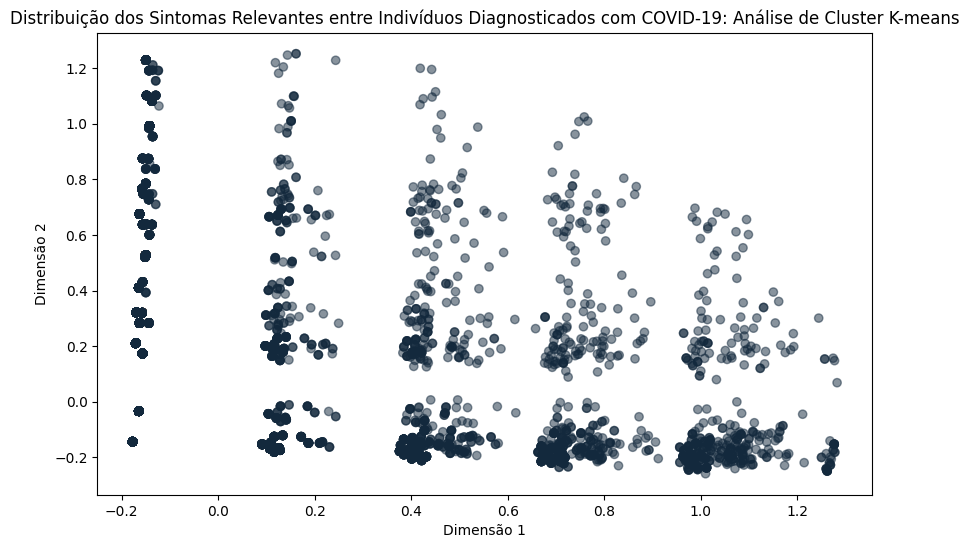

In [171]:
plt.figure(figsize=(10, 6))

# Definindo uma cor personalizada para os pontos
cores = ['#13293D'] * len(resultados_mca)  # Cor única para todos os pontos, altere como necessário

# Scatterplot
plt.scatter(resultados_mca[0], resultados_mca[1], alpha=0.5, c=cores)

# Adicionando rótulos e título
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.title('Distribuição dos Sintomas Relevantes entre Indivíduos Diagnosticados com COVID-19: Análise de Cluster K-means')

# Exibindo o gráfico
plt.show()

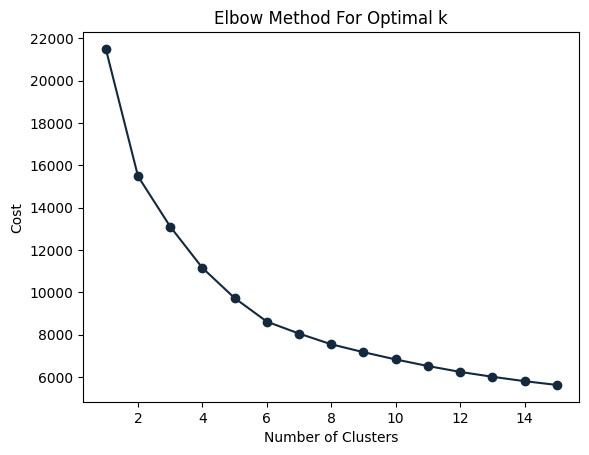

In [153]:
#Utilização do Elbow Method para determinar o número ideal de clusters em uma análise de clustering, usando o algoritmo K-Modes

# Preparando os dados para o método
df_elbow = resultados_mca[[0, 1]].copy()
cost = []

# Calculando o custo para diferentes números de clusters
for num_clusters in range(1, 16):
    kmodes = KModes(n_clusters=num_clusters, init='Cao', n_init=5, verbose=0)
    kmodes.fit_predict(df_elbow)
    cost.append(kmodes.cost_)

# Plotando o gráfico com a cor personalizada
plt.plot(range(1, 16), cost, marker='o', color='#13293D')  # Cor alterada para roxo

# Adicionando título e rótulos
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')

# Exibindo o gráfico
plt.show()


Número de clusters: 2, Silhouette Score: 0.707
Número de clusters: 3, Silhouette Score: 0.756
Número de clusters: 4, Silhouette Score: 0.751
Número de clusters: 5, Silhouette Score: 0.858
Número de clusters: 6, Silhouette Score: 0.876
Número de clusters: 7, Silhouette Score: 0.875
Número de clusters: 8, Silhouette Score: 0.867
Número de clusters: 9, Silhouette Score: 0.864
Número de clusters: 10, Silhouette Score: 0.876
Número de clusters: 11, Silhouette Score: 0.885
Número de clusters: 12, Silhouette Score: 0.889
Número de clusters: 13, Silhouette Score: 0.889
Número de clusters: 14, Silhouette Score: 0.891
Número de clusters: 15, Silhouette Score: 0.921


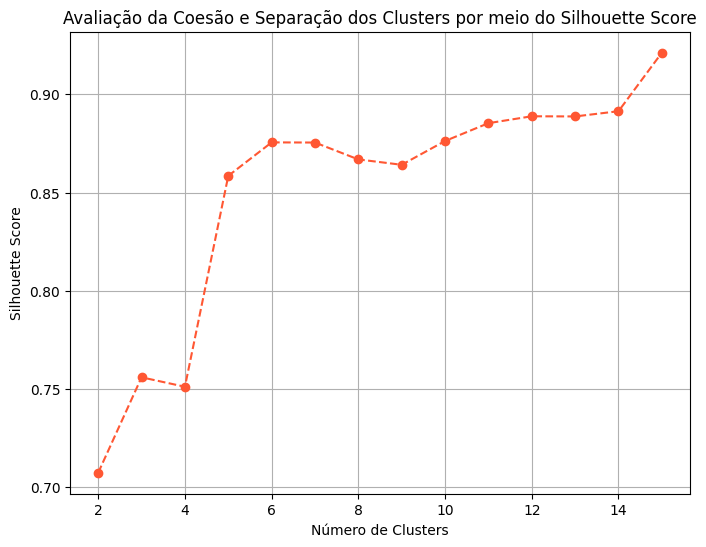

In [172]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Inicializando o intervalo de números de clusters a serem testados
range_n_clusters = list(range(2, 16))
silhouette_scores = []

# Calculando o Silhouette Score para diferentes números de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(resultados_mca[[0, 1]])
    silhouette_avg = silhouette_score(resultados_mca[[0, 1]], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Número de clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

# Plotando o gráfico com a cor personalizada
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--', color='#FF5733')  # Cor personalizada (vermelho-alaranjado)

# Adicionando título e rótulos aos eixos
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Avaliação da Coesão e Separação dos Clusters por meio do Silhouette Score')

# Exibindo a grade e o gráfico
plt.grid(True)
plt.show()


In [159]:
# Definicção do número de clusters
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(resultados_mca[[0, 1]])
resultados_mca['cluster'] = clusters
consolidado_cluster = base_analise_cluster.loc[resultados_mca.index].copy()
consolidado_cluster[[0 , 1 , 'distancia', 'cluster']] = resultados_mca
consolidado_cluster.rename(columns={0: 'x', 1: 'y'}, inplace=True)
consolidado_cluster.head()

,B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,...,B0102,B0103,B0104,B0105,B0106,positivo_covid,x,y,distancia,cluster
15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,-0.177306,-0.143683,0.228215,0
16,False,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,True,0.683384,-0.187175,0.708554,3
17,False,True,False,False,False,False,False,True,False,False,...,True,True,False,False,False,True,0.734132,0.775919,1.068176,5
20,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,-0.170629,0.210279,0.270798,7
31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,-0.177306,-0.143683,0.228215,0


In [160]:
# Contagem de tuplas
consolidado_cluster.groupby('cluster').size().reset_index(name='counts').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
counts,20525,261,1421,322,570,112,570,3567,323,221,460,181,1406,147,1189


In [161]:
# Cálculo de desvio padrão
analise_cluster = consolidado_cluster.groupby('cluster')[['x', 'y']].agg(['median', 'std']).T.round(2)
analise_cluster

cluster     0     1     2     3     4     5     6     7     8     9     10  \
x median -0.18 -0.15 -0.17  0.71 -0.16  0.51  0.12 -0.17  1.03  0.12  0.41   
  std     0.00  0.07  0.01  0.05  0.06  0.17  0.03  0.01  0.09  0.03  0.04   
y median -0.14  1.23  0.32 -0.17  0.76  0.70 -0.15  0.21 -0.19  0.23 -0.17   
  std     0.00  0.06  0.04  0.04  0.09  0.15  0.04  0.01  0.05  0.10  0.04   

cluster     11    12    13    14  
x median  0.97 -0.16  0.43 -0.16  
  std     0.17  0.06  0.08  0.00  
y median  0.21  0.68  0.22 -0.03  
  std     0.13  0.05  0.08  0.00

In [163]:
#Análise de relevância de variável
media_x, media_y = analise_cluster.loc[('x', 'median'), :].describe().loc['75%'], analise_cluster.loc[('y', 'median'), :].describe().loc['75%']
clusters_x = analise_cluster.T[analise_cluster.T['x', 'median'] >= media_x].reset_index()
clusters_y = analise_cluster.T[analise_cluster.T['y', 'median'] >= media_y].reset_index()

In [164]:
#Junção de cluster relevantes em x e y
clusters_xy = pd.concat([clusters_y, clusters_x], ignore_index=True)
clusters_xy.T

0     1     2      3     4     5     6      7
cluster         1.00  4.00  5.00  12.00  3.00  5.00  8.00  11.00
x       median -0.15 -0.16  0.51  -0.16  0.71  0.51  1.03   0.97
        std     0.07  0.06  0.17   0.06  0.05  0.17  0.09   0.17
y       median  1.23  0.76  0.70   0.68 -0.17  0.70 -0.19   0.21
        std     0.06  0.09  0.15   0.05  0.04  0.15  0.05   0.13

In [165]:
#Remoção de clusters com alto valor no desvio padrão
mean_stdX, mean_stdY = clusters_xy['x', 'std'].mean(), clusters_xy['y', 'std'].mean()
std_stdX, std_stdY = clusters_xy['x', 'std'].std(), clusters_xy['y', 'std'].std()
limite_stdX, limite_stdY = (mean_stdX + 2 * std_stdX), (mean_stdY + 2 * std_stdY)
clusters_a_excluir = clusters_xy[(clusters_xy['x', 'std'] > limite_stdX) | (clusters_xy['y', 'std'] > limite_stdY)]
clusters_a_excluir

Empty DataFrame
Columns: [(cluster, ), (x, median), (x, std), (y, median), (y, std)]
Index: []

In [166]:
#Média da frequência de sintomas nos clusters relevantes
dados_graficos_cluster = consolidado_cluster.groupby('cluster')[sintomas].mean().loc[clusters_xy['cluster']]
dados_graficos_cluster

,B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,B00111,B00112,B00113
cluster,,,,,,,,,,,,,
1,0.003831,0.003831,0.000000,0.000000,0.011494,0.003831,0.000000,0.000000,0.007663,0.000000,0.007663,0.026820,0.000000
4,0.003509,0.010526,0.003509,0.000000,0.008772,0.000000,0.000000,0.003509,0.003509,0.000000,0.007018,0.007018,0.001754
5,0.169643,0.294643,0.125000,0.151786,0.330357,0.080357,0.080357,0.232143,0.312500,0.017857,0.187500,0.366071,0.053571
12,0.000000,0.007112,0.001422,0.002845,0.005690,0.000000,0.000000,0.002134,0.004267,0.000000,0.004267,0.004979,0.002134
3,0.431677,0.372671,0.341615,0.111801,0.468944,0.074534,0.065217,0.260870,0.226708,0.024845,0.254658,0.298137,0.055901
5,0.169643,0.294643,0.125000,0.151786,0.330357,0.080357,0.080357,0.232143,0.312500,0.017857,0.187500,0.366071,0.053571
8,0.591331,0.501548,0.371517,0.160991,0.613003,0.086687,0.095975,0.284830,0.340557,0.080495,0.414861,0.458204,0.092879
11,0.359116,0.464088,0.303867,0.165746,0.535912,0.088398,0.110497,0.243094,0.381215,0.088398,0.248619,0.414365,0.143646


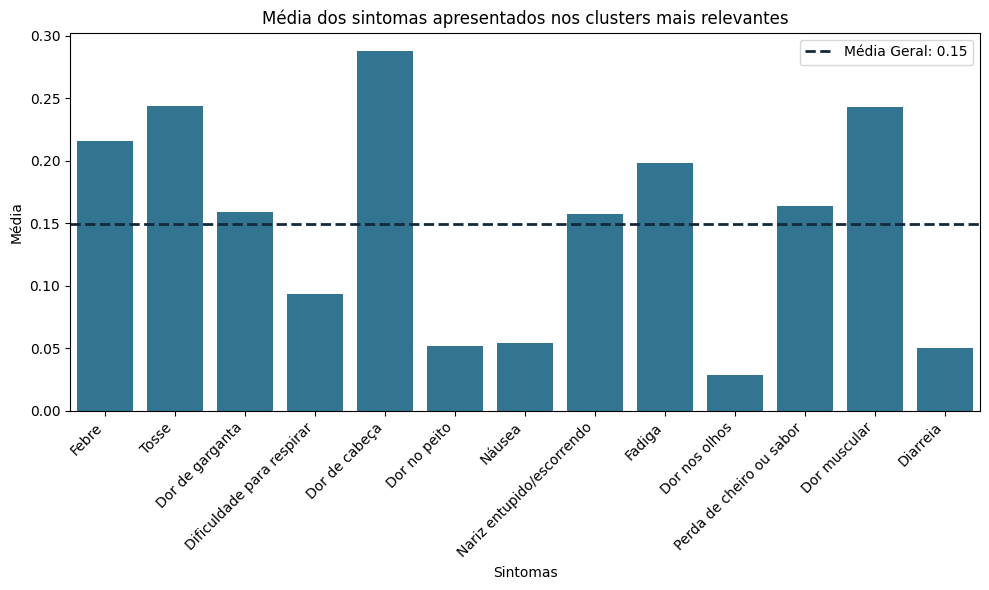

In [168]:
# Calculando a média dos dados
media_dados = dados_graficos_cluster.mean()
media_dados.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar',
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo',
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular',
                          'B00113': 'Diarreia'}, inplace=True)

# Configurando o gráfico de barras
plt.figure(figsize=(10, 6))

# Alterando a cor das barras
sns.barplot(x=media_dados.index, y=media_dados.values, color='#247BA0')  # Cor personalizada para as barras

# Rotacionando os rótulos do eixo X
plt.xticks(rotation=45, ha='right')

# Calculando a média geral
media_geral = media_dados.mean()

# Adicionando a linha da média geral
plt.axhline(y=media_geral, color='#13293D', linestyle='--', linewidth=2, label=f'Média Geral: {media_geral:.2f}')  # Cor personalizada para a linha

# Adicionando título e rótulos
plt.title('Média dos sintomas apresentados nos clusters mais relevantes')
plt.xlabel('Sintomas')
plt.ylabel('Média')

# Adicionando a legenda
plt.legend()

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()